In [6]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import pickle 
from util import accuracy
from training_util_mae2 import (MyDataset, split, Transformer_park, Transformer_pretrain,
                        base_model, base_decoder, hierachy_model, train, validate, weighted_sampling,
                              eval_model)
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm 

import torch
import os
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, auc, roc_auc_score,
                             precision_recall_curve, roc_curve, average_precision_score)
from sklearn.preprocessing import label_binarize
import easydict


<ipython-input-6-33c134fd411a>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


### define loading model 

In [7]:
def loading_model(args, loaded_model):
    b_model = base_model(n_each_base = args.n_each_base,
                         mask_on=args.mask_on)
    vital_model = Transformer_park(n_each_lab = args.n_each_vital,
                                       n_embed = args.n_embed, 
                                       nhead = args.nhead, 
                                       nhid = args.nhid, 
                                       nlayers = args.nlayers, 
                                       dropout = args.dropout, 
                                       mask_on = args.mask_on)
    lab_model = Transformer_park(n_each_lab = args.n_each_lab,
                                     n_embed = args.n_embed, 
                                     nhead = args.nhead, 
                                     nhid = args.nhid, 
                                     nlayers = args.nlayers, 
                                     dropout = args.dropout, 
                                     mask_on = args.mask_on )
    decoder_vital = Transformer_pretrain(n_each_lab = args.n_each_vital,
                                        n_embed = args.n_embed)
    decoder_lab = Transformer_pretrain(n_each_lab = args.n_each_lab,
                                       n_embed = args.n_embed)
    decoder_base = base_decoder(n_each_base = args.n_each_base)
    total_model = hierachy_model(vital_shape = args.vital_shape, 
                                 lab_shape = args.lab_shape, 
                                 batch_size =args.test_batchsize, 
                                 output_len = args.output_len)

    vital_model.load_state_dict(loaded_model['vital_model_dict'])
    lab_model.load_state_dict(loaded_model['lab_model_dict'])
    b_model.load_state_dict(loaded_model['b_model_dict'])
    total_model.load_state_dict(loaded_model['total_model_dict'])
    decoder_vital.load_state_dict(loaded_model['decoder_vital_dict'])
    decoder_lab.load_state_dict(loaded_model['decoder_lab_dict'])
    decoder_base.load_state_dict(loaded_model['decoder_base_dict'])
    
    vital_model.eval()
    lab_model.eval()
    b_model.eval()
    total_model.eval()
    decoder_vital.eval()
    decoder_lab.eval()
    decoder_base.eval()

    return vital_model, lab_model, b_model, total_model, decoder_vital, decoder_lab, decoder_base

In [8]:
def predicted_outcome(test_loader, vital_model, lab_model, b_model, total_model, 
                decoder_vital, decoder_lab, decoder_base):
    for batch, batch_data in enumerate(test_loader):
        vital_set = batch_data[0]
        lab_set = batch_data[1]
        baseline_set = batch_data[2]
        each_att_vital_set = batch_data[3]
        each_att_lab_set = batch_data[4]
        each_att_base_set = batch_data[5]
        att_vital_set = batch_data[6]
        att_lab_set = batch_data[7]
        outcome = batch_data[8]
        outcome = outcome.type(torch.LongTensor)

        vital_tensor = vital_model(vital_set.transpose(0,1), att_vital_set,
                                   each_mask = each_att_vital_set.transpose(0,1))
        lab_tensor = lab_model(lab_set.transpose(0,1), att_lab_set,
                               each_mask = each_att_lab_set.transpose(0,1))
        base_tensor = b_model(baseline_set, each_att_base_set)

        vital_out = decoder_vital(vital_tensor)  
        lab_out = decoder_lab(lab_tensor)    
        base_out = decoder_base(base_tensor) 

        #compute loss
        result = total_model(vital_tensor, lab_tensor, base_tensor)
        
        if batch==0:
            result_t = result.cpu().detach()
            outcome_t =outcome.cpu().detach()
        else:
            result_t = torch.cat([result.cpu(), result_t],axis=0).detach()
            outcome_t = torch.cat([outcome.cpu(), outcome_t],axis=0).detach()
            
    return result_t, outcome_t

In [9]:
def auroc_auprc(predicted, outcome):
    val_acc1, val_acc2 = accuracy(predicted, outcome, topk=(1,2))
    soft = nn.Softmax(dim=1)
    s_predicted = soft(predicted).detach().numpy()
    outcome_onehot = label_binarize(outcome, classes=[0,1,2])

    avscore = average_precision_score(outcome_onehot, s_predicted, average='weighted')
    val_acc1 = val_acc1.item()
    roc_weight_val = roc_auc_score(outcome_onehot, s_predicted, 
                                   multi_class= 'ovr', average = 'weighted')

    return val_acc1, roc_weight_val, avscore

In [10]:
args = easydict.EasyDict({"masking_value": 0, #masking value selection 
                          "batch_size": 1000, #number of each batch 
                          "file_name": "../whole_3data0630_o2_idscale.txt",
                          "min_epoch": 200, #minimum epoch for training
                          "n_epochs_stop": 10, #stop epoch after nth training without performance gain
                          "epochs": 1000, #maximum epoch 
                          "early_stop": True, #setting of early stopping
                          "nhead": 4,  #transformer number of head
                          "n_embed": 160, #transformer number of embedding layer
                          "nhid": 320, #transformer number of hidden layer
                          "nlayers": 4, #transformenr encoder layer number
                          "dropout": 0.2, #drop out 
                          "lr_": 5e-5, #learning rate
                          "weight_decay_": 1e-4, #weight decay
                          "output_len": 3, #number of output category number
                          "prior_d":0, #prediction day 0 or day 1 or day 2
                          "weight": 1.0, #weight of decoder loss
                          "mae": False, #use of masked autoencoder 
                          "mask_on":True, #use of masking layer
                          "masking_ratio": 0., #MAE ratio when it used
                          "metric": 'total_loss', #early stopping reference 
                          "cuda_i" : 1, #cuda device number
                            "save_path" : "./save_confidence_interval" #save folder name 
                          })

In [11]:
number=2; padded_hosday = 18

train_set, valid_set, test_set = split(args.file_name, random_s=number) 

args.n_each_vital = train_set[0][2].shape[-1]
args.n_each_lab = train_set[0][1].shape[-1]
args.n_each_base = train_set[0][0].shape[-1]

args.vital_shape = padded_hosday*3*args.n_embed
args.lab_shape = padded_hosday*args.n_embed

def get_filepath(path):
    filename = [x for x in os.listdir(path) if "hos18" in x and "model2" in x]
    if len(filename)==1:
        filepath = path+filename[0]
    return filepath

filepath0 = get_filepath("./save_confidence_interval/")
filepath1 = get_filepath("./save_confidence_interval_day1/")
filepath2 = get_filepath("./save_confidence_interval_day2/")

### each output AUROC 

In [12]:
def get_predicted(filepath0, prior_day):
    loaded_model_0 = torch.load(filepath0)
    test_dataset = MyDataset(args.masking_value, test_set, 
                             padded_hosday, data_pr = 1, prior_d=prior_day)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset),
                                 shuffle=False, drop_last=True)
    args.test_batchsize = len(test_dataset)
    load_0 = loading_model(args, loaded_model_0)
    predicted, outcome = predicted_outcome(test_loader, load_0[0], load_0[1],
                                   load_0[2],load_0[3], load_0[4], load_0[5], load_0[6])
    predicted = pd.DataFrame(predicted)
    predicted['outcome']=outcome
    return predicted

In [13]:
predicted0 = get_predicted(filepath0, prior_day = 0)
predicted1 = get_predicted(filepath1, prior_day = 1)
predicted2 = get_predicted(filepath2, prior_day = 2)

pred_result = [predicted0, predicted1, predicted2]

* the result of get_predicted is each outcome and the likelihood of each label by 3-dimensional spaces

In [18]:
pred_result[0].head()

,0,1,2,outcome
0,5.295092,1.053508,-7.107789,0
1,5.882860,0.988131,-7.606773,0
2,6.766726,0.699998,-8.325313,0
3,7.315381,0.612466,-8.893425,0
4,8.634735,-0.080958,-9.621277,0


### draw the each AUROC and AUPRC by target outcome and prediction day 

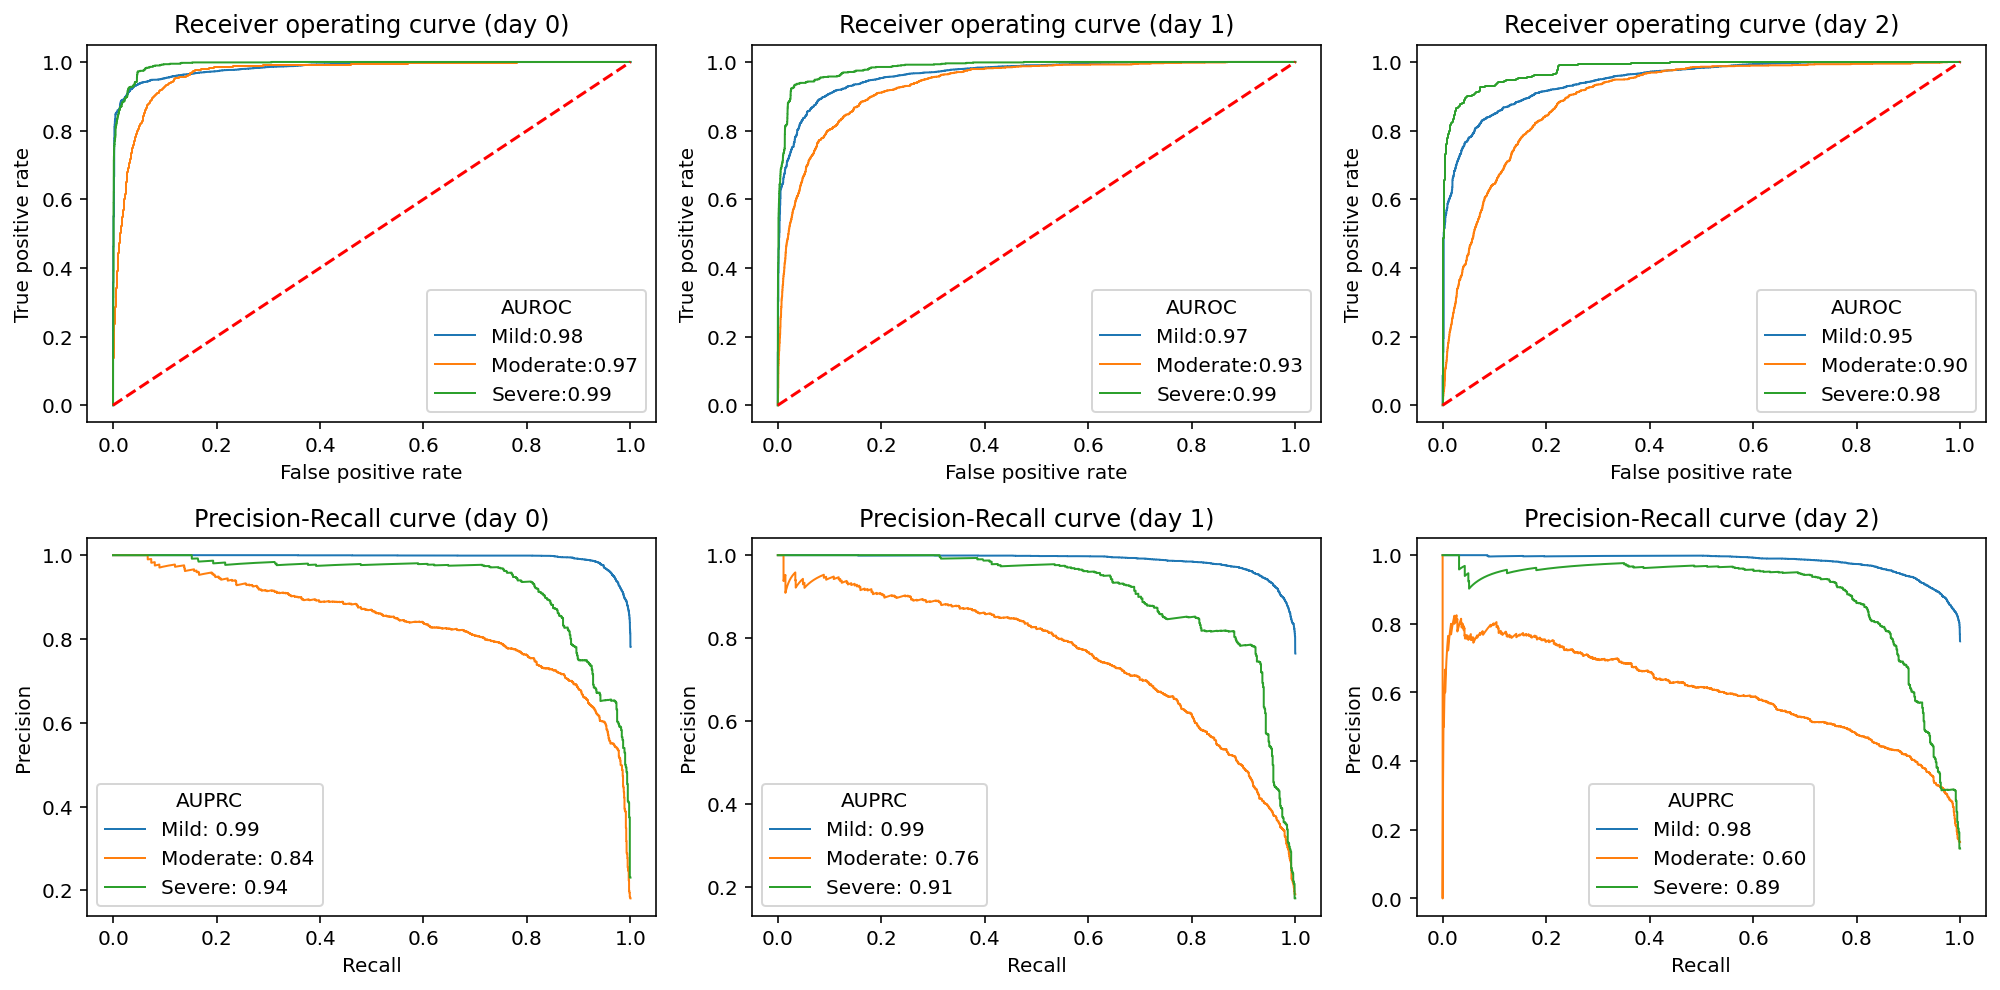

In [15]:
labels = {0:"Mild",
         1:"Moderate",
         2:"Severe"}

fig, ax = plt.subplots(2,3, figsize = (14,7))

def draw_each_fig(fig_i,outcome_onehot,predicted, name):
    precision = dict()
    recall = dict()
    roc_pr = dict()
    fpr = dict()
    tpr = dict()
    roc_auc_ = dict()
    
    ax_ = ax[1, fig_i]
    
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(outcome_onehot[:,i], predicted[:,i])
        roc_pr[i] = average_precision_score(outcome_onehot[:,i], predicted[:,i])
        ax_.plot(recall[i], precision[i], lw=1, label=f"{labels[i]}: {roc_pr[i]:.2f}")
    ax_.set_xlabel("Recall")
    ax_.set_ylabel("Precision")
    ax_.legend(title = "AUPRC", loc="best")
    ax_.set_title(f"Precision-Recall curve ({name})")

    ax_1 = ax[0, fig_i]
    for i in range(3):
        fpr[i], tpr[i],_ = roc_curve(outcome_onehot[:,i], predicted[:,i])
        roc_auc_[i] = auc(fpr[i],tpr[i])
        ax_1.plot(fpr[i], tpr[i], lw=1, label=f"{labels[i]}:{roc_auc_[i]:.2f}")
    ax_1.set_xlabel("False positive rate")
    ax_1.set_ylabel("True positive rate")
    ax_1.plot([0, 1], [0, 1],'r--')
    ax_1.legend(title = "AUROC", loc="best")
    ax_1.set_title(f"Receiver operating curve ({name})")
    
names = ["day 0","day 1","day 2"]

for fig_i, predict_ in enumerate(pred_result):
    result = torch.tensor(predict_[[0,1,2]].values)
    outcome = predict_['outcome']
    soft = nn.Softmax(dim=1)
    predicted = soft(result).detach().numpy()
    outcome_onehot = label_binarize(outcome, classes=[0,1,2])
    name = names[fig_i]
    draw_each_fig(fig_i,outcome_onehot,predicted, name)

plt.tight_layout()
plt.show()
